# Demonstration of Robust Mean and Covariance Estimation by GANs

- [1. Simulation Example](# 1. A Simulation Example)
- [2. Application: Outlier Detection & Robust Cov Estimation in Stock Markets ](# 2. APPLICATION: Outlier Detection & Robust Cov Estimation in Stock Markets)
- [3. Robust PCA of Stock Market using Robust Gaussian Cov Estimate](#3. Robust PCA)

In [2]:
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
import time
import os

import numpy as np
import pandas as pd
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal

from fgan import fgan

# Assume that we are on a CUDA machine, then this should print a CUDA device:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cuda


## 1. A Simulation Example

We generate data under Huber Contamination model:
$$ x_i \sim 0.8 {\mathcal{N}}(0,I_p) + 0.2 {\mathcal{N}}(5*1_p, 2*I_p),$$
with $N=50000$ samples and dimension $p=50$.

In [3]:
## initialize data 80% Gaussian(0_p, I_p) and 20% Gaussian(5*1_p, 2*I_p)
## where dimension p=50, sample size N=50000
XReal = np.random.normal(loc=0., scale=1., size=(40000, 50))
XCont = np.random.normal(loc=5., scale=2., size=(10000, 50))
XData = np.concatenate( (XReal, XCont), axis=0 )
print(XData.shape)

(50000, 50)


Epoch:25, LossD/G:1.3065/-0.6220


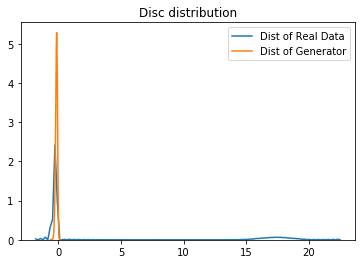

Epoch:50, LossD/G:1.2345/-0.5850


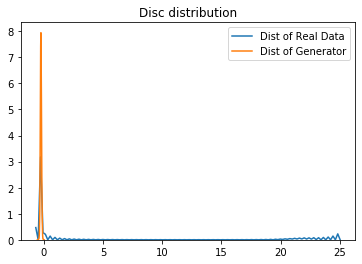

Epoch:75, LossD/G:1.2386/-0.5901


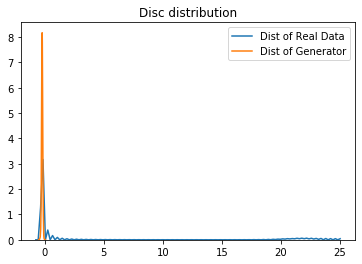

Epoch:100, LossD/G:1.2410/-0.5926


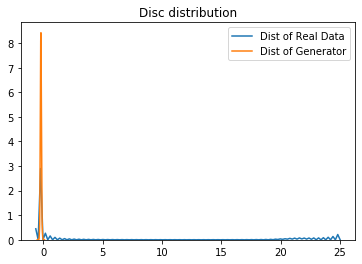

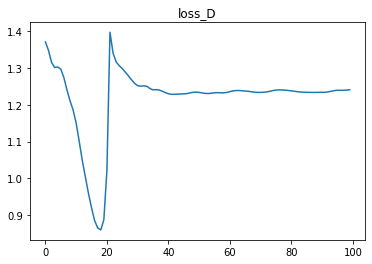

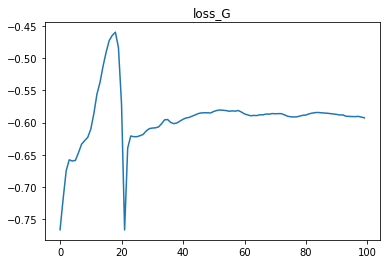

Time for running this cell: 195.85s


In [4]:
s0 = time.time()
f0 = fgan(50, 0.0, device, epsilon=1e-5)
f0.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f0.data_init(batch_size = 100, 
             data = torch.from_numpy( XData[np.random.shuffle(np.arange(50000))].squeeze() ).float() )
f0.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f0.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f0.fit(floss='js', epochs=100, avg_epochs=20,
       verbose=25, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

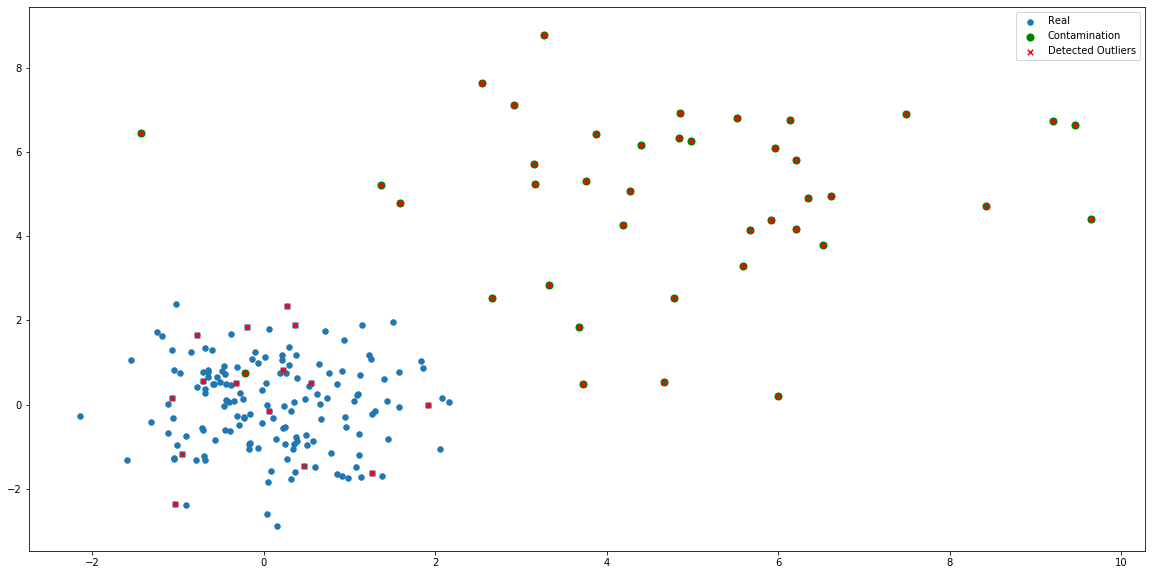

In [5]:
## G-score for 
XTest = torch.from_numpy( np.concatenate( (XReal[:160], XCont[:40]), axis=0 ) ).float()
## Discriminator score for generator samples
Gsamples = f0.netG( torch.randn(10000, f0.p).to(device) )
DGscore = f0.netD(Gsamples)[1].detach().cpu().numpy()
Dscore = f0.netD(XTest.to(device))[1].detach().cpu().numpy()
outlierIndex = (Dscore > np.percentile(DGscore, 95)) | (Dscore < np.percentile(DGscore, 5))
## visualize on first two coordinates
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter( XReal[:160, 0], XReal[:160, 1], s=30, c="C0", label="Real")
ax.scatter( XCont[:40, 0], XCont[:40, 1], s=50, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:160], XCont[:40]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=30, c="r", label="Detected Outliers" )
ax.legend()
plt.show()

The figures above show that the generator captures the normal distribution of samples and the discriminator identifies outliers (green points) together with a few normal samples (blue points).

## 2. APPLICATION: Outlier Detection & Robust Cov Estimation in Stock Markets

We select 50 stocks during the period between 2015-01-01 and 2020-04-01 from Yahoo! Finance. 

In [6]:
corps_dict = {
         "Industrial":["LMT", "HON", "UNP", "BA", "MMM", "UPS"],
         "ConsDiscr":["AMZN", "HD", "MCD", "NKE", "SBUX", "LOW"],
         "ConsStaples":["WMT", "PG", "KO", "PEP", "COST", "PM"],
         "Energy":["XOM", "CVX", "COP", "KMI", "PSX", "EOG"],
         "HealthCare":["JNJ", "UNH", "MRK", "PFE", "ABT", "LLY"],
         "Financial":["JPM", "BAC", "WFC", "C", "AXP", "BLK"],
         "InfoTech":["MSFT", "AAPL", "V", "MA", "INTC", "CSCO"],
         "Material":["LIN", "ECL", "APD", "NEM", "SHW", "DD"],
         "Utility":["NEE", "D", "DUK", "SO", "AEP", "SRE"],
         "CommSevs": ["GOOG", "FB", "VZ", "T", "DIS", "NFLX"]
            }

corps = []; sects = [] ## list of corporations and their corresponding sectors
for k, v in corps_dict.items():
    corps += v[:5]
    sects += [k] * 5

tks = yf.Tickers( " ".join(corps) )

START = "2015-01-01"; END = "2020-04-01"
df_price = tks.history(start=START, end=END)["Close"]

[*********************100%***********************]  50 of 50 completed


### Visualizing the return of stocks selected from different sectors

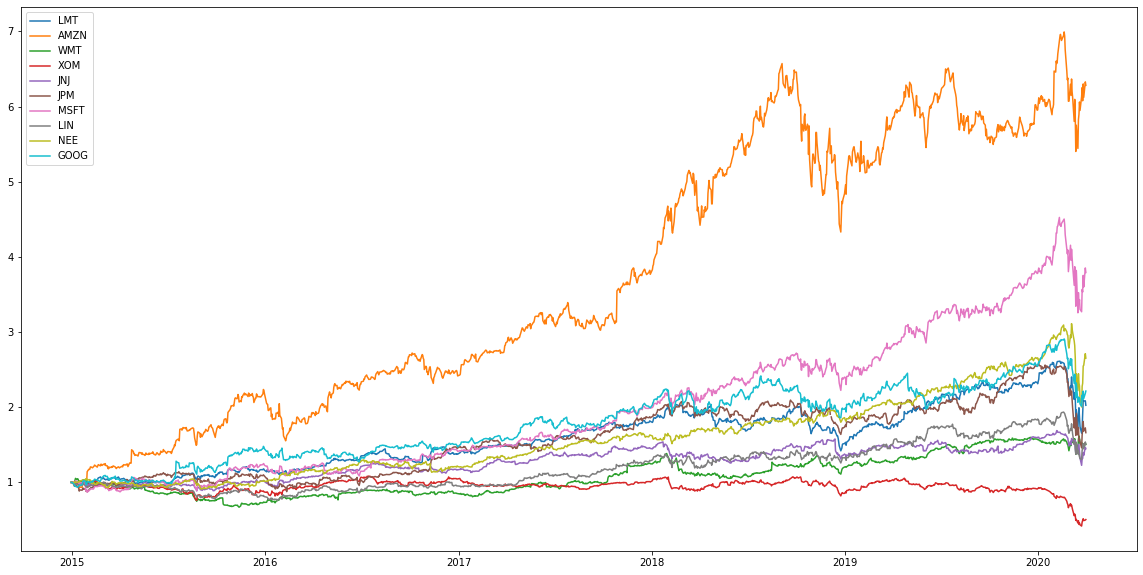

In [7]:
fig, ax = plt.subplots(figsize=(20,10))

for sym in list(zip(*corps_dict.values()))[0]:
    ax.plot(df_price[sym]/df_price[sym].iloc[0], label=sym)
ax.legend()
plt.show()

In [8]:
df_ret = df_price/df_price.shift(1) # daily return
dropIdx = df_ret["AAPL"].index[ df_ret["AAPL"].apply( np.isnan ) ]
df_ret = df_ret.drop( dropIdx )
logret = np.log( df_ret.to_numpy() ) # daily log-return
logret = logret / logret.std() # re-scale
logret_tensor = torch.from_numpy( logret ).float()

Epoch:250, LossD/G:1.3694/-0.6856


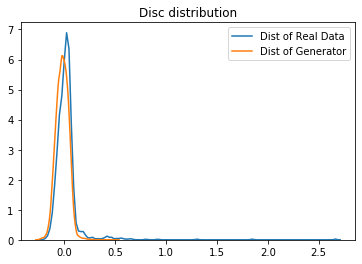

Epoch:500, LossD/G:1.3497/-0.6814


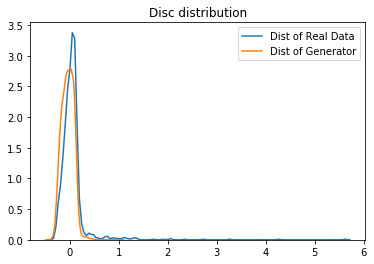

Epoch:750, LossD/G:1.3293/-0.6659


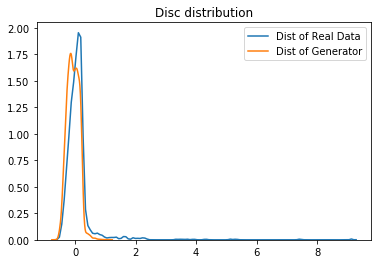

Epoch:1000, LossD/G:1.3072/-0.6448


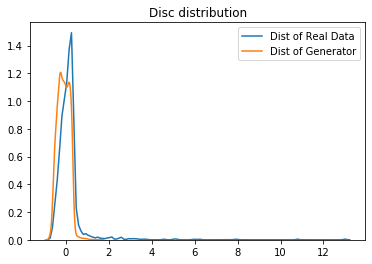

Epoch:1250, LossD/G:1.2918/-0.6195


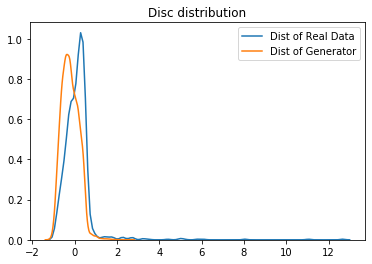

Epoch:1500, LossD/G:1.2840/-0.6401


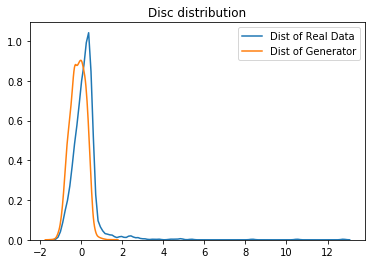

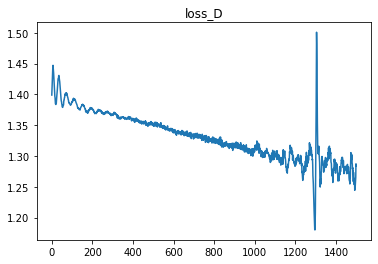

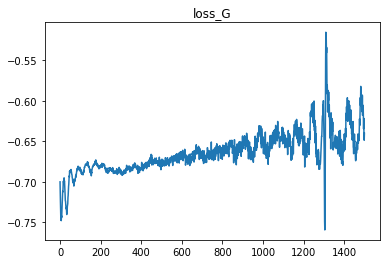

Time for running this cell: 231.66s


In [9]:
## Fitted by Gaussian
s0 = time.time()
f1 = fgan(50, 0.0, device, epsilon=1e-5)
f1.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f1.data_init(batch_size=25, data=logret_tensor)
f1.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f1.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f1.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Gaussian fits the distribution somehow well, though with a more symmetric distribution.  

Epoch:250, LossD/G:1.3881/-0.7028


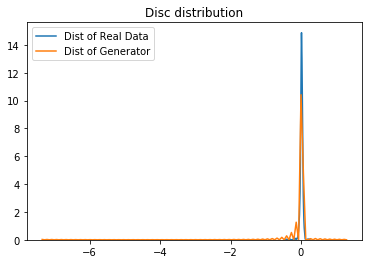

Epoch:500, LossD/G:1.3781/-0.6995


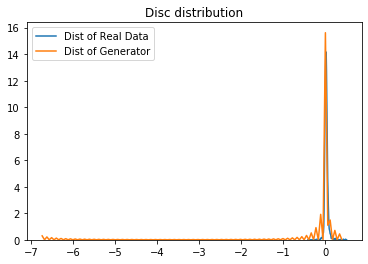

Epoch:750, LossD/G:1.3740/-0.6893


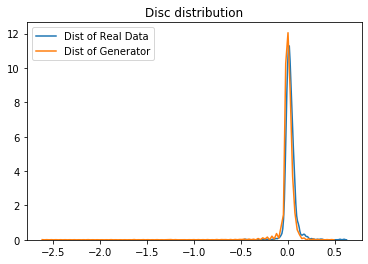

Epoch:1000, LossD/G:1.3698/-0.6919


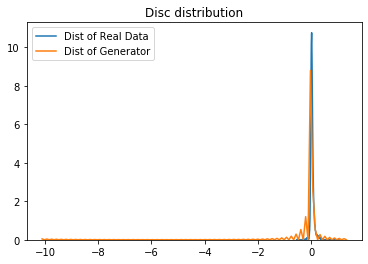

Epoch:1250, LossD/G:1.3590/-0.6832


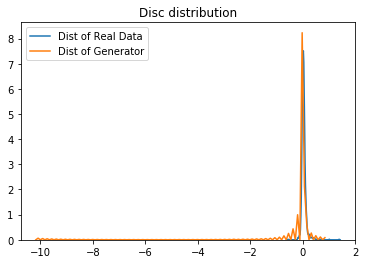

Epoch:1500, LossD/G:1.3537/-0.6885


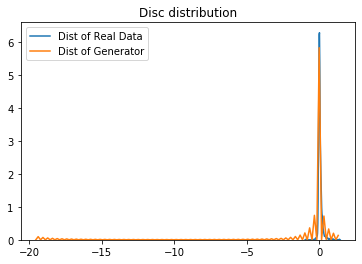

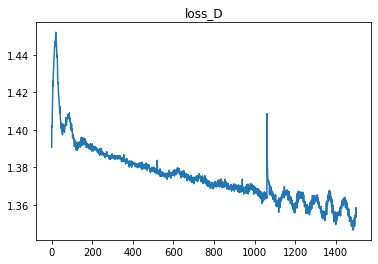

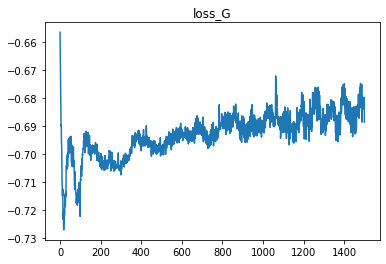

Time for running this cell: 148.62s


In [10]:
## Fitted by Student-t
s0 = time.time()
f2 = fgan(50, 0.0, device, epsilon=1e-5)
f2.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f2.data_init(batch_size=50, data=logret_tensor)
f2.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f2.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f2.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Student-$t$ seems a better fit than Gaussian though with more oscillations. 

Epoch:250, LossD/G:1.3953/-0.6995


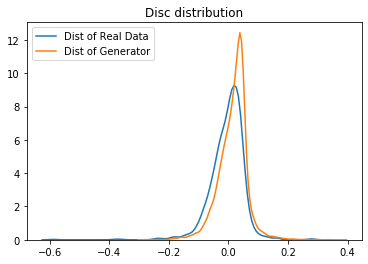

Epoch:500, LossD/G:1.3811/-0.6933


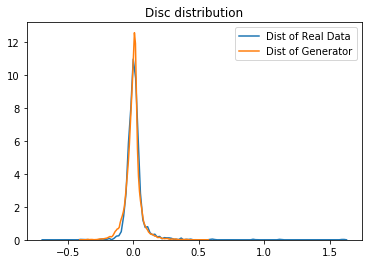

Epoch:750, LossD/G:1.3789/-0.6864


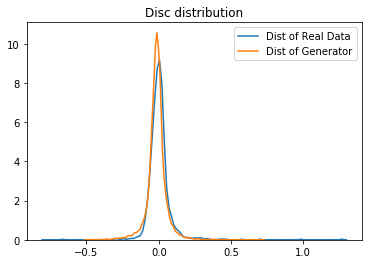

Epoch:1000, LossD/G:1.3725/-0.6904


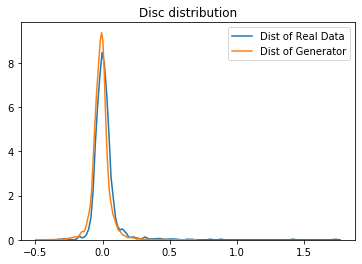

Epoch:1250, LossD/G:1.3716/-0.6831


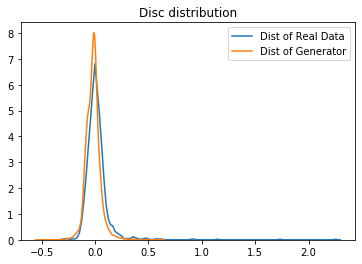

Epoch:1500, LossD/G:1.3647/-0.6833


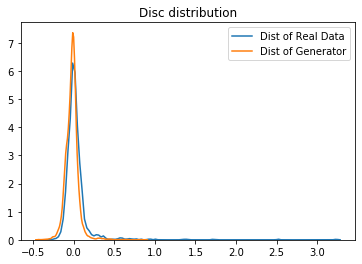

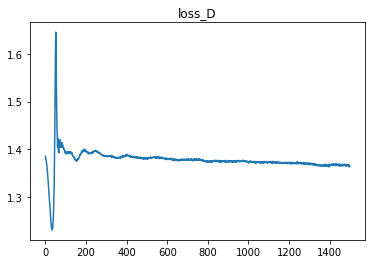

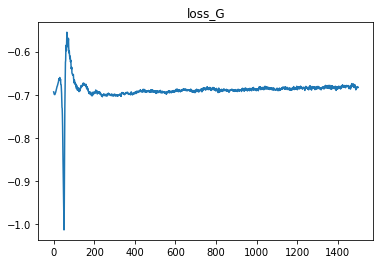

Time for running this cell: 149.04s


In [11]:
## Fitted by Elliptical
s0 = time.time()
f3 = fgan(50, 0.0, device, epsilon=1e-5)
f3.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f3.data_init(batch_size=50, data=logret_tensor)
f3.net_init(hidden_units=[100, 25], hidden_units_G=[25, 10], input_dim_G=10, use_bias=True,
            elliptical=True, init_D='xavier', init_D1=0.025, init_G='kendall',
            activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f3.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f3.fit(floss='js', epochs=1500, avg_epochs=50, inverse_gaussian=False,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

So general elliptical distribution seems with better fitting performance here than Gaussian and Student-$t$. 

### Outlier detection by Discriminator

Outlier is defined as samples whose discriminator values larger or smaller than $99.75$, or $1$ percentile estimated from learned generator, respectively.

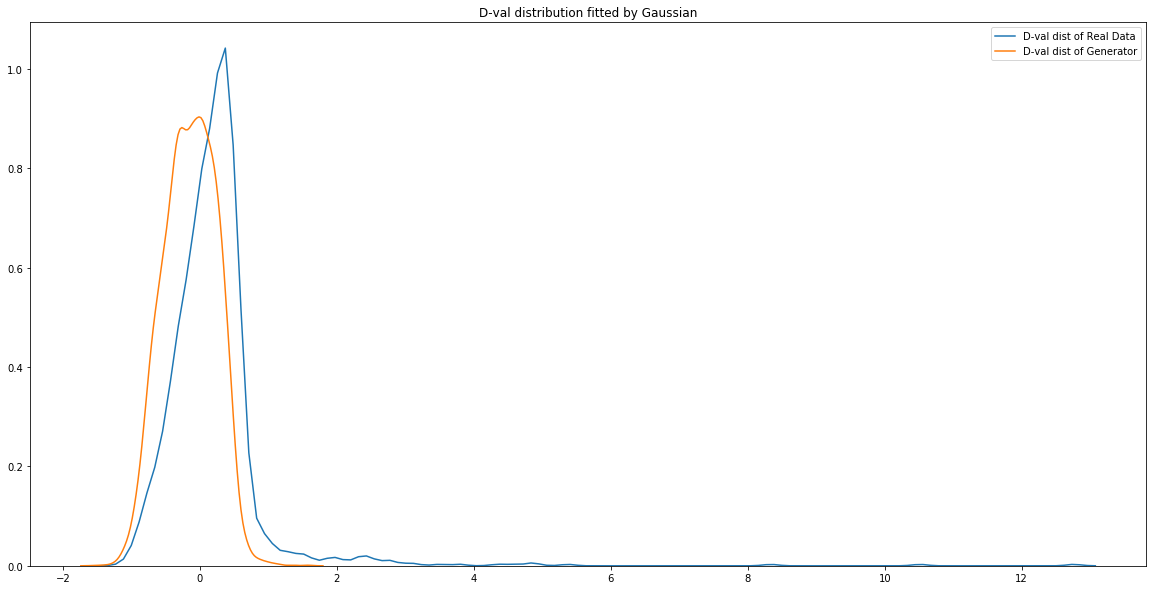

73 outliers are detected by Gaussian fit


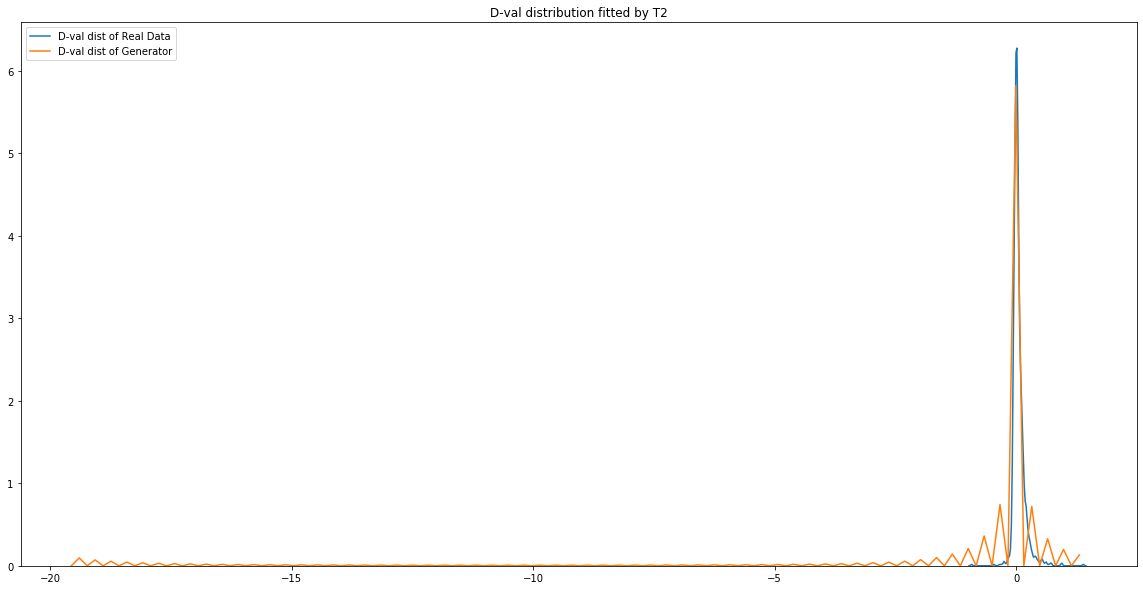

28 outliers are detected by T2 fit


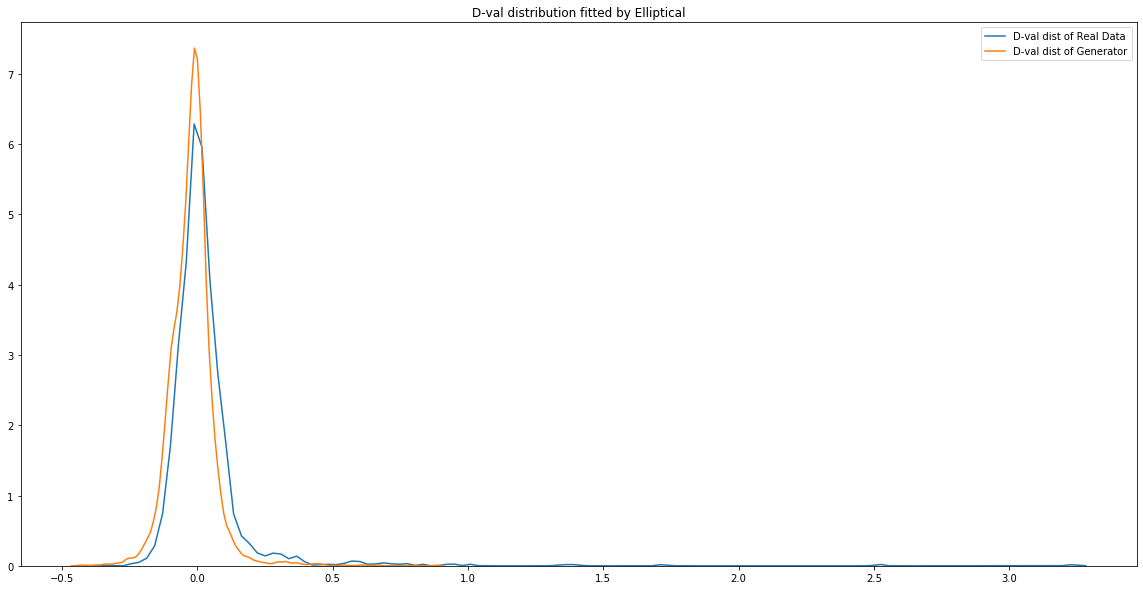

27 outliers are detected by Elliptical fit


In [12]:
outlierIndex = {}
model = ['Gaussian', 'T2', "Elliptical"]

for i in range(3):
    f = eval("f"+str(i+1))
    fig, ax = plt.subplots(figsize=(20,10))

    real_D = f.netD(f.Xtr.to(device))[1].detach().cpu().numpy()
    ## generating sample score
    if not f.elliptical:
        if f.true_type == 'Student':
            temp_z = torch.randn(10000, f.p).to(device) # [N, p]
            temp_z.div_(torch.sqrt(f.t_chi2_d.sample((10000, 1))/f.t_df).to(device) + f.epsilon)
            temp_g = f.netG(temp_z)
        elif f.true_type == 'Gaussian':
            temp_g = f.netG(torch.randn(10000, f.p).to(device))

    else:
        temp_u = torch.randn(10000, f.p).to(device)
        temp_u.data.div_(temp_u.norm(2, dim=1).view(-1, 1) + f.epsilon)
        if f.inverse_gaussian:
            temp_xi1 = torch.randn(10000, f.input_dim_G//2).to(device)
            temp_xi2 = torch.randn(10000, f.input_dim_G//2).to(device)
            temp_xi2.data = 1/(torch.abs(temp_xi2.data) + f.epsilon)
            temp_xi = f.netGXi(torch.cat([temp_xi1, temp_xi2], dim=1)).view(10000, -1)
        else:
            temp_xi = f.netGXi(torch.randn(10000, f.input_dim_G).to(device)).view(10000, -1)
        temp_g = f.netG(temp_u, temp_xi)

    gene_D = f.netD(temp_g)[1].detach().cpu().numpy()

    sns.distplot(f.real_D, hist=False, label='D-val dist of Real Data')
    sns.distplot(f.gene_D, hist=False, label='D-val dist of Generator')
    plt.legend()
    plt.title('D-val distribution fitted by ' + model[i])
    plt.show()
    
    # outlier is defined as data with discriminator value larger(smaller) than
    # 99.75(1) percentile estimated from learned generator.
    outlierIndex[i] = (real_D > np.percentile(gene_D, 99.75)) | (real_D < np.percentile(gene_D, 1))
    print( "{} outliers are detected by {} fit".format( outlierIndex[i].sum(), model[i]) )
    #print(np.std(gene_D))



In [14]:
## Import S&P 500 Index and see what happens at outlier date.
import pandas_datareader.data as web
import datetime

SPX = web.DataReader(['sp500'], 'fred', START, END)
SPX = SPX.loc[df_ret.index]

/home/yuany/.conda/envs/mypython3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


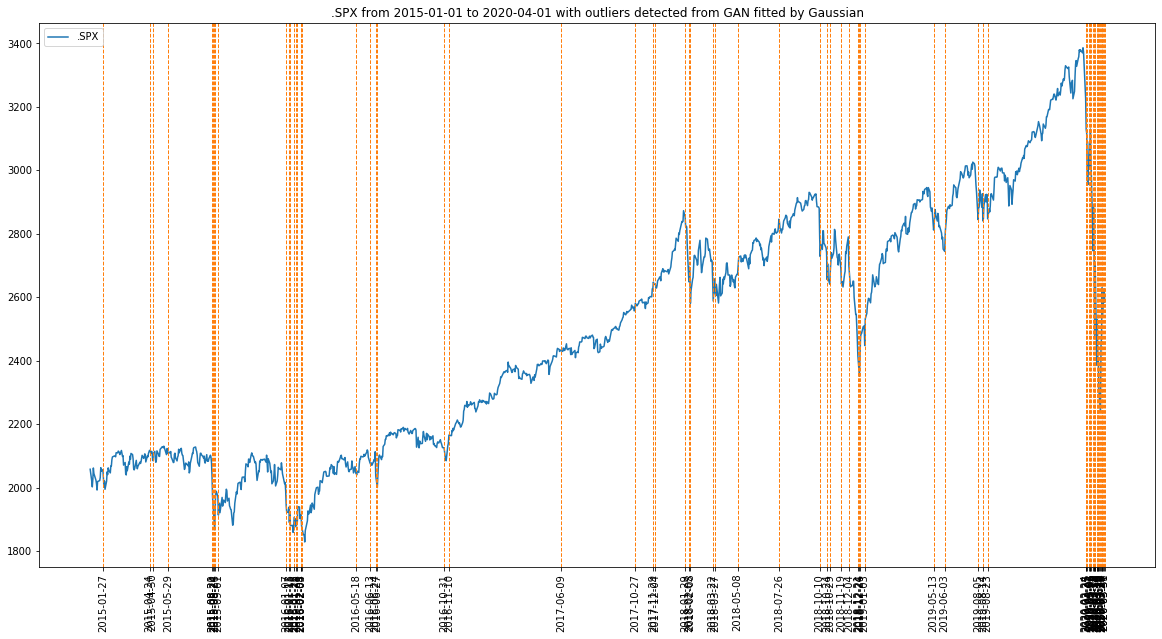

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[0]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected from GAN fitted by Gaussian".format(START, END) )
plt.show()

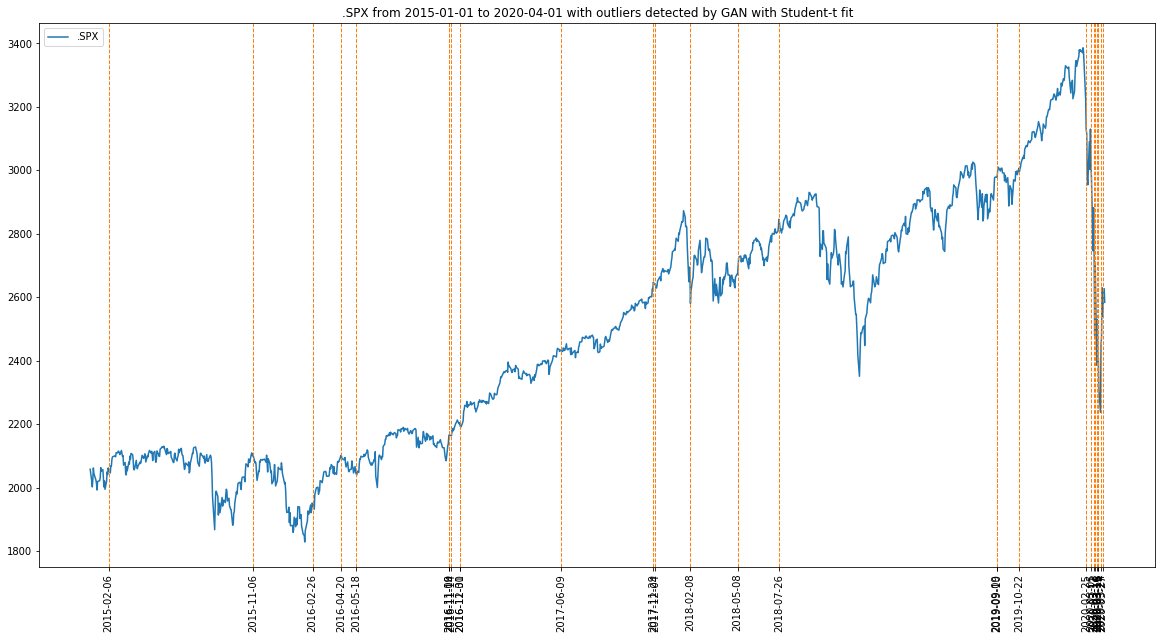

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[1]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected by GAN with Student-t fit".format(START, END) )
plt.show()

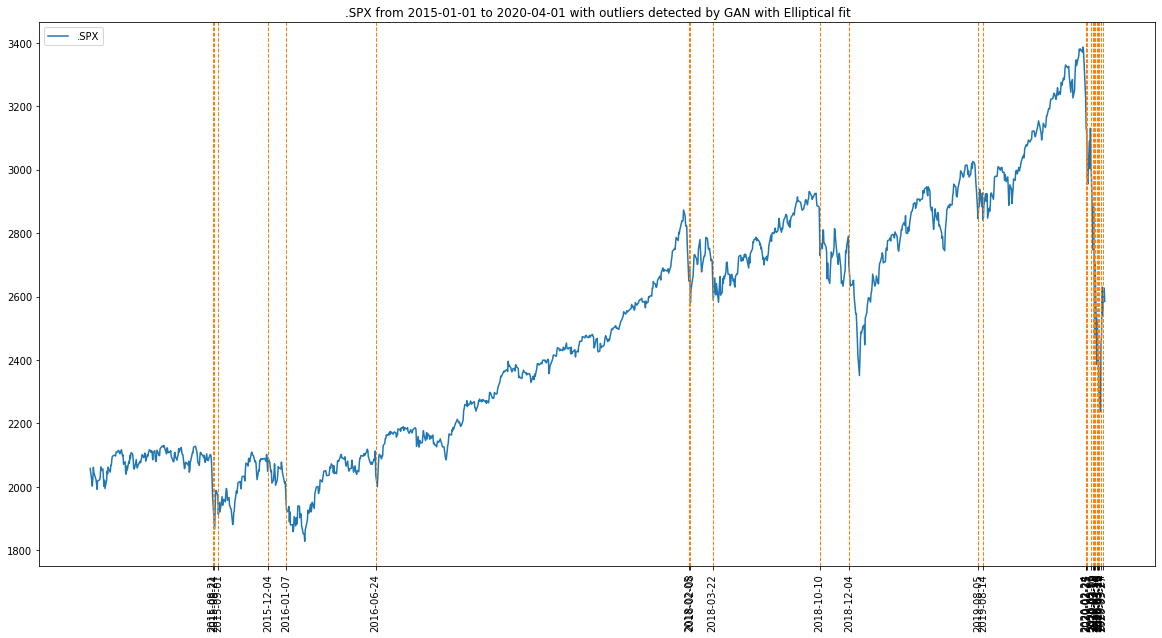

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[2]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected by GAN with Elliptical fit".format(START, END) )
plt.show()

## 3. Robust PCA

Now we reselect daily prices of 50 stocks during the period between 2007-01-01 and 2018-12-31. This includes the 2008 financial tsunami.  

In [18]:
corps_dict = {
         "Industrial":["LMT", "HON", "UNP", "BA", "MMM", "UPS"],
         "ConsDiscr":["AMZN", "HD", "MCD", "NKE", "SBUX", "LOW"],
         "ConsStaples":["WMT", "PG", "KO", "PEP", "COST", "PM"],
         "Energy":["XOM", "CVX", "COP", "VLO", "EOG"],
         "HealthCare":["JNJ", "UNH", "MRK", "PFE", "ABT", "LLY"],
         "Financial":["JPM", "BAC", "WFC", "C", "AXP", "BLK"],
         "InfoTech":["MSFT", "AAPL", "MA", "INTC", "CSCO"],
         "Material":["LIN", "ECL", "APD", "NEM", "SHW", "DD"],
         "Utility":["NEE", "D", "DUK", "SO", "AEP", "SRE"],
         "CommSevs": ["GOOG", "VZ", "T", "DIS", "NFLX"]
            }

corps = []; sects = [] ## list of corporations and their corresponding sectors
for k, v in corps_dict.items():
    corps += v[:5]
    sects += [k] * 5

tks = yf.Tickers( " ".join(corps) )

START = "2007-01-01"; END = "2018-12-31"
df_price = tks.history(start=START, end=END)["Close"]

df_ret = df_price/df_price.shift(1) # daily return
dropIdx = df_ret["AAPL"].index[ df_ret["AAPL"].apply( np.isnan ) ]
df_ret = df_ret.drop( dropIdx )
logret = np.log( df_ret.to_numpy() ) # daily log-return
logret = logret / logret.std() # re-scale
logret_tensor = torch.from_numpy( logret ).float()

[*********************100%***********************]  50 of 50 completed


Epoch:250, LossD/G:1.3597/-0.6766


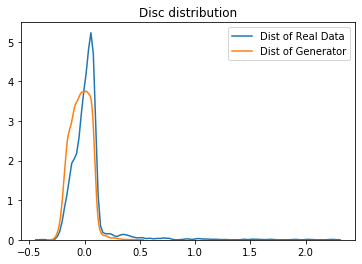

Epoch:500, LossD/G:1.3119/-0.6631


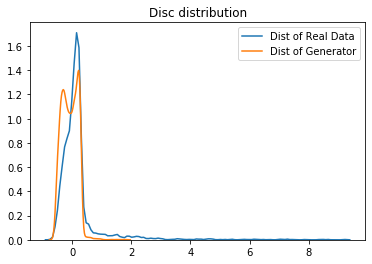

Epoch:750, LossD/G:1.3132/-0.6704


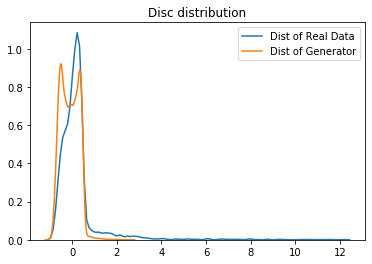

Epoch:1000, LossD/G:1.2560/-0.6065


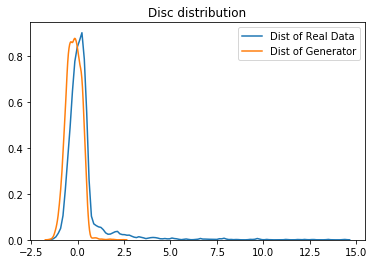

Epoch:1250, LossD/G:1.2844/-0.6253


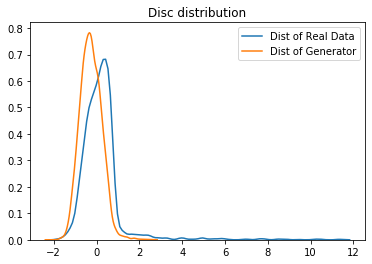

Epoch:1500, LossD/G:1.1674/-0.5659


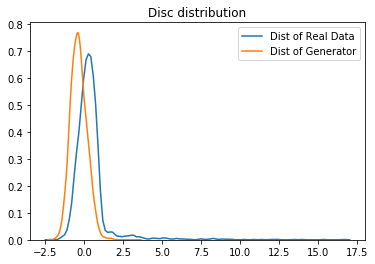

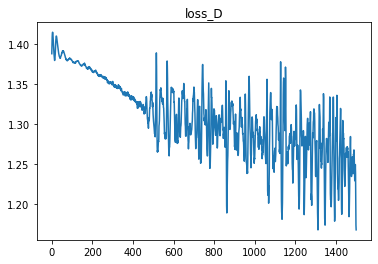

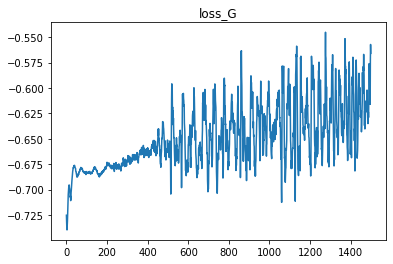

Time for running this cell: 618.21s


In [19]:
## Fitted by Gaussian
s0 = time.time()
f1 = fgan(50, 0.0, device, epsilon=1e-5)
f1.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f1.data_init(batch_size=25, data=logret_tensor)
f1.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f1.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f1.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit( logret )

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

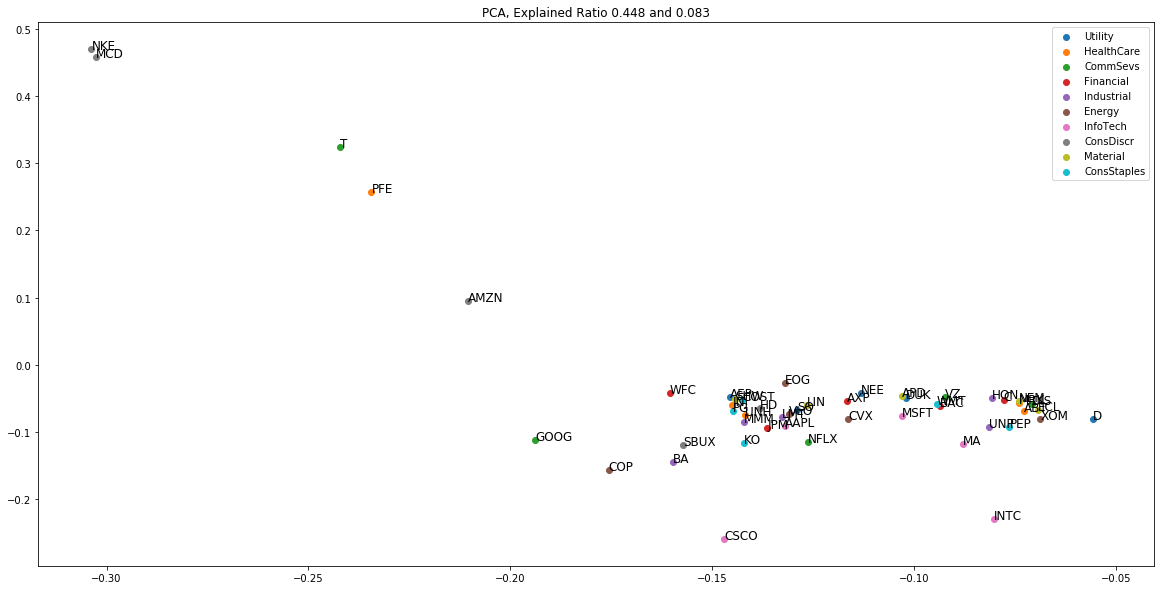

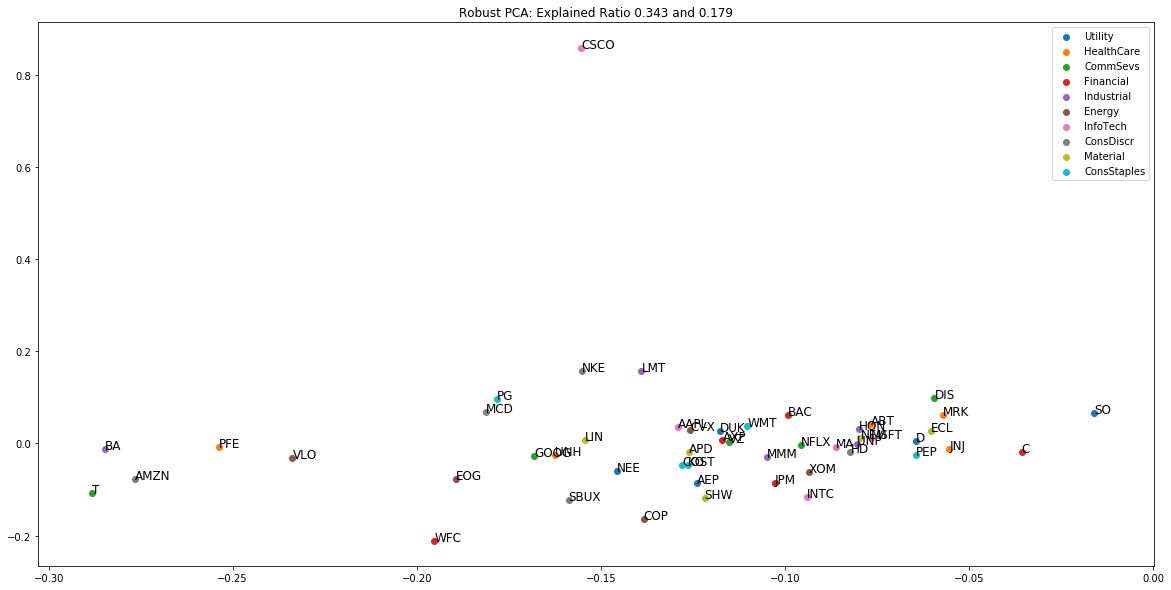

In [27]:
cov0 = pca.get_covariance()
s0, v0 = scipy.linalg.eigh(cov0)
fig, ax = plt.subplots(figsize=(20,10))
for sect in set(sects):
    idx = (np.array(sects) == sect)
    ax.scatter(v0[idx,-1], v0[idx,-2], label=sect)
for i, txt in enumerate(corps):
    ax.annotate(txt, (v0[:,-1][i], v0[:,-2][i]),size=12)
plt.legend()
plt.title('PCA, Explained Ratio %.3f and %.3f' % ((s0/s0.sum())[-1], (s0/s0.sum())[-2]))
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
f = eval("f"+str(1))
A = f.netG.weight.data.cpu().numpy()
cov = np.matmul(A.T, A)
s, v = scipy.linalg.eigh(cov)
for sect in set(sects):
    idx = (np.array(sects) == sect)
    ax.scatter(v[idx,-1], v[idx,-2], label=sect)
for i, txt in enumerate(corps):
    ax.annotate(txt, (v[:,-1][i], v[:,-2][i]),size=12)
plt.legend()
plt.title('Robust PCA: Explained Ratio %.3f and %.3f' % 
          ((s/s.sum())[-1], (s/s.sum())[-2]))
plt.show()



Original PCA using standard covariance matrix is shown on top figure and Robust PCA using Gaussian covariance matrix estimated by GAN is shown on bottom figure. In top figure the original PCA is largely influenced by a few companies with instability, while the robust PCA in the bottom figure gives a stabler visualiztion with more spreads on the 50 companies by attenuating outliers. 

Epoch:250, LossD/G:1.3870/-0.6903


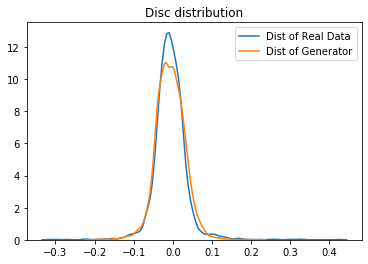

Epoch:500, LossD/G:1.3798/-0.6916


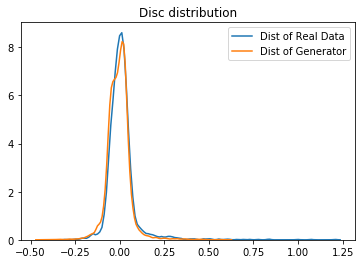

Epoch:750, LossD/G:1.3810/-0.6900


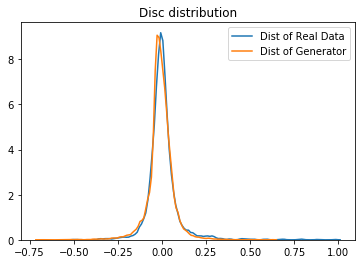

Epoch:1000, LossD/G:1.3651/-0.6831


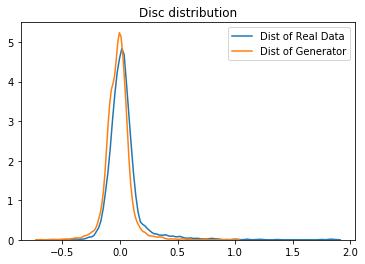

Epoch:1250, LossD/G:1.3571/-0.6823


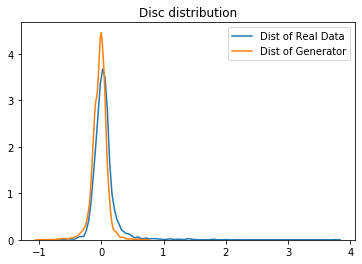

Epoch:1500, LossD/G:1.3461/-0.6770


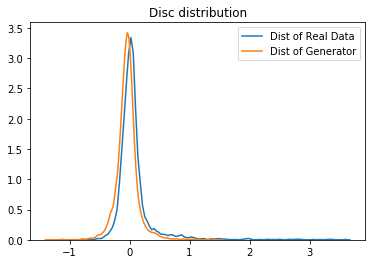

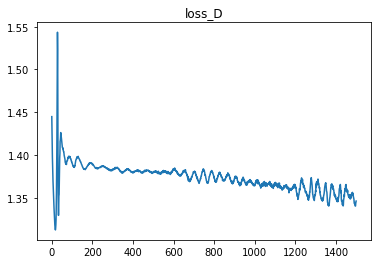

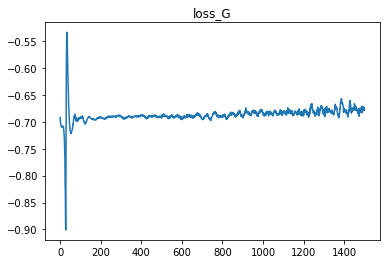

Time for running this cell: 340.39s


In [22]:
## Fitted by Elliptical
s0 = time.time()
f3 = fgan(50, 0.0, device, epsilon=1e-5)
f3.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f3.data_init(batch_size=50, data=logret_tensor)
f3.net_init(hidden_units=[100, 25], hidden_units_G=[25, 10], input_dim_G=10, use_bias=True,
            elliptical=True, init_D='xavier', init_D1=0.025, init_G='kendall',
            activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f3.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f3.fit(floss='js', epochs=1500, avg_epochs=50, inverse_gaussian=False,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

The Ellptical fitting seems better than Gaussian fit.

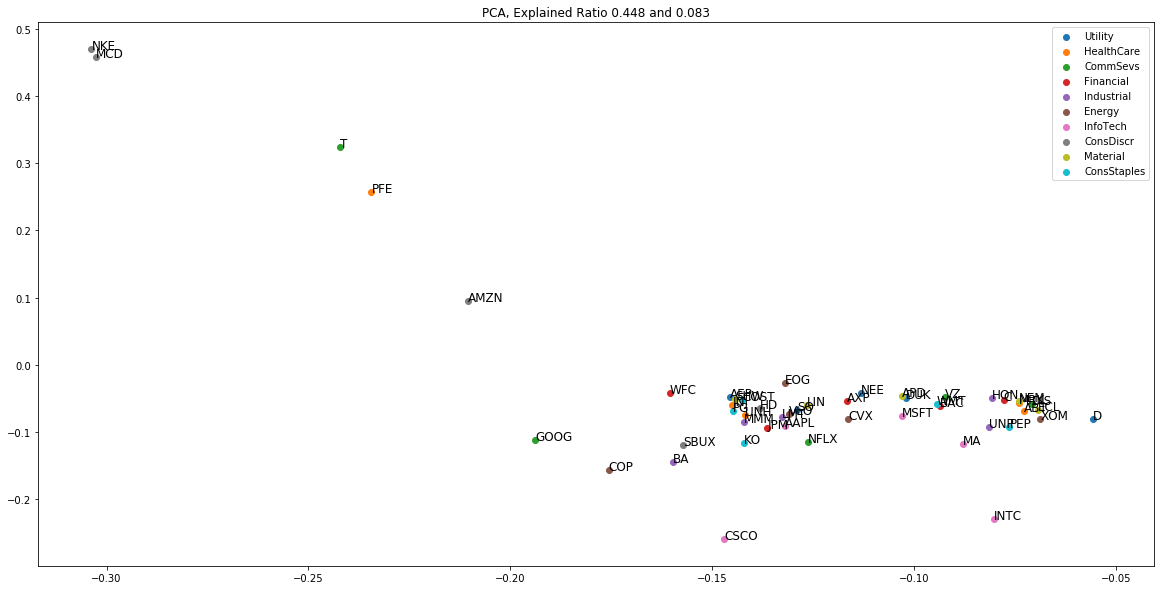

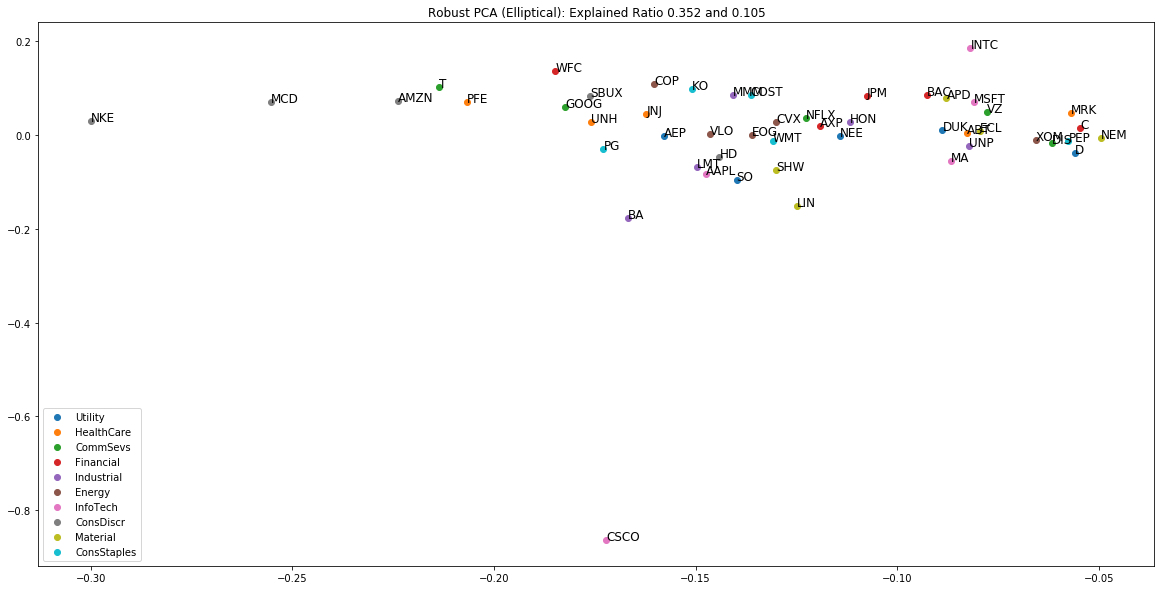

In [23]:
cov0 = pca.get_covariance()
s0, v0 = scipy.linalg.eigh(cov0)
fig, ax = plt.subplots(figsize=(20,10))
for sect in set(sects):
    idx = (np.array(sects) == sect)
    ax.scatter(v0[idx,-1], v0[idx,-2], label=sect)
for i, txt in enumerate(corps):
    ax.annotate(txt, (v0[:,-1][i], v0[:,-2][i]),size=12)
plt.legend()
plt.title('PCA, Explained Ratio %.3f and %.3f' % ((s0/s0.sum())[-1], (s0/s0.sum())[-2]))
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
#f = eval("f"+str(3))
A = f3.netG.weight.data.cpu().numpy()
cov = np.matmul(A.T, A)
s, v = scipy.linalg.eigh(cov)
for sect in set(sects):
    idx = (np.array(sects) == sect)
    ax.scatter(v[idx,-1], v[idx,-2], label=sect)
for i, txt in enumerate(corps):
    ax.annotate(txt, (v[:,-1][i], v[:,-2][i]),size=12)
plt.legend()
plt.title('Robust PCA (Elliptical): Explained Ratio %.3f and %.3f' % 
          ((s/s.sum())[-1], (s/s.sum())[-2]))
plt.show()




Top: Original PCA using standard covariance matrix; Bottom: Robust PCA using robust elliptical scatter matrix estimated by GAN. In top figure the original PCA is largely influenced by a few companies with instability, while the robust PCA in the bottom figure gives a stabler visualiztion with more spreads on the 50 companies by attenuating outliers. From the quality of fitting, the robust PCA with Elliptical fitting should be better than Gaussian fitting. 